<a href="https://colab.research.google.com/github/yehfanju/hello-world/blob/master/ND_Bert_Embed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 簡單情緒極度分類

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from itertools import chain, product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import random
random.seed(1234)

## 詞彙列表

In [ ]:
hao = "好吃 好看 好玩 好聽 好用".split()
nann = "難吃 難看 難過 難聽 難用".split()
nouns = "音樂 遊戲 作業 單車 電影".split()
places = "學校 公園 餐廳 路口 台北".split()

In [ ]:
word_enc = LabelEncoder()
word_list = hao + nann + nouns + places
word_ids = word_enc.fit_transform(word_list)
word_groups = {}
for w in word_enc.classes_:
  if w in hao: c="#6666FF"; g=("hao", 0)
  elif w in nann: c="#FF6666"; g=("nann", 1)  
  elif w in nouns: g = ("noun", 2)
  elif w in places: g = ("places", 3)
  word_groups[w] = g
  # word_colors.append(c)
word_labels = [word_groups[w][1] for w in word_list]

## 詞彙嵌入表徵

### 預訓練分類模型

In [ ]:
class WordClassifier(nn.Module):
  def __init__(self, V, dim):
    super(WordClassifier, self).__init__()
    self.emb = nn.Embedding(V, dim)
    self.classifier = nn.Linear(dim, 4)
  
  def get_word_embeddings(self):
    return self.emb.weight
    
  def forward(self, X):
    vec = self.emb(X)
    out = self.classifier(vec)
    return out

### 訓練迴圈

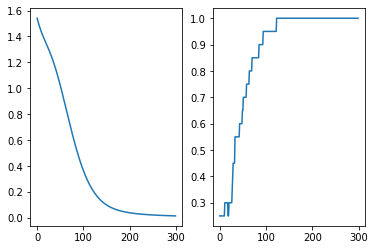

In [ ]:
torch.manual_seed(1234)
model = WordClassifier(len(word_enc.classes_), 2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
init_emb = model.get_word_embeddings().clone().detach().numpy()

loss_vec = []
acc_vec = []
X = torch.tensor(word_ids)
y = torch.tensor(word_labels)
for _ in range(300):
  optimizer.zero_grad()
  preds = model(X).squeeze()
  loss = loss_fn(preds, y)
  
  loss.backward()
  optimizer.step()

  loss_vec.append(loss.item())
  acc_vec.append(accuracy_score(word_labels, preds.argmax(axis=1).detach().numpy()))

fig, axes = plt.subplots(1, 2, facecolor="white")
axes[0].plot(loss_vec)
axes[1].plot(acc_vec)

### 視覺化嵌入表徵

In [ ]:
def visualize_boundary(emb, group_ids, func):
  x1min, x2min = np.min(emb, axis=0) - 0.5
  x1max, x2max = np.max(emb, axis=0) + 0.5
  xx, yy = np.meshgrid(np.arange(x1min, x1max, 0.05), np.arange(x2min, x2max, 0.05))
  newX = np.hstack([
        xx.flatten().reshape(xx.size, 1),
        yy.flatten().reshape(yy.size, 1)])
  new_out = func(torch.tensor(newX, dtype=torch.float))
  new_cat = torch.softmax(new_out, axis=1).argmax(axis=1).detach().numpy()
  zz = new_cat.reshape(xx.shape)    
  plt.contourf(xx, yy, zz, cmap="coolwarm")
  scatter = plt.scatter(emb[:, 0], emb[:, 1], c=group_ids)    
  legend1 = plt.gca().legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
  plt.gca().add_artist(legend1)

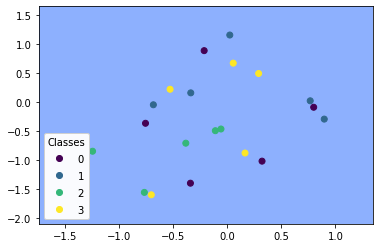

In [ ]:
word_group_ids = [word_groups[w][1] for w in word_enc.classes_]
visualize_boundary(init_emb, word_group_ids, lambda x: torch.zeros_like(x))

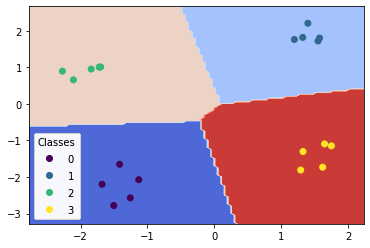

In [ ]:
word_embs = model.emb.weight.detach().numpy()
word_group_ids = [word_groups[w][1] for w in word_enc.classes_]
visualize_boundary(word_embs, word_group_ids, model.classifier)

## 判斷詞彙序列的情緒極度

### 資料前處裡

In [ ]:
seqs_words = []
seqs_ids = []
seqs_labels = []
seq_gen = chain(product(hao+nann, nouns, places))                
for x in seq_gen:
  y = list(x)
  random.shuffle(y)
  seqs_words.append(y)
  seqs_ids.append(word_enc.transform(y))
  seqs_labels.append(1 if x[0] in hao else 0)

In [ ]:
# 輸入資料的維度是 250(序列數目) x 3(每個序列的詞彙個數) x 2(嵌入表徵的維度)
model.emb(torch.tensor(seqs_ids)).shape

torch.Size([250, 3, 2])

In [ ]:
ss = list(zip(seqs_words, seqs_labels))
random.shuffle(ss)
for a, b in ss[:10]:
  print(" ".join(a),b)

好用 作業 公園 1
難用 學校 音樂 0
好用 單車 公園 1
學校 單車 好看 1
好吃 作業 路口 1
作業 難過 路口 0
作業 難過 學校 0
難聽 餐廳 遊戲 0
難過 台北 音樂 0
單車 好聽 公園 1


### 定義模型

In [ ]:
class WordSeqPolarity(nn.Module):
  def __init__(self, emb):
    super(WordSeqPolarity, self).__init__()
    self.emb = nn.Embedding.from_pretrained(emb, freeze=True)
    dim = self.emb.embedding_dim
    self.classifier = nn.Linear(dim, 1)    
    self.att1 = nn.Linear(dim, 4)
    self.att2 = nn.Linear(4, 1)

  def get_attention_weights(self, Xemb, softmax=True):
    a1 = torch.tanh(self.att1(Xemb))
    a2 = self.att2(a1)
    if softmax:
      score = a2.softmax(axis=1)
    else:
      score = a2
    return score
    
  def forward(self, X):    
    vec = self.emb(X)
    # att_score: batch_size x 1 x seq_len    
    att_score = self.get_attention_weights(vec).transpose(1, 2)
    ctx_vec = torch.bmm(att_score, vec).squeeze()                
    out = torch.sigmoid(self.classifier(ctx_vec))        
    return out, att_score

### 訓練迴圈

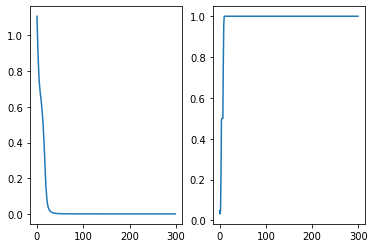

In [ ]:
torch.manual_seed(12345)
amodel = WordSeqPolarity(model.emb.weight)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.AdamW(amodel.parameters(), lr=1e-1)
loss_vec = []
acc_vec = []

for _ in tqdm(range(300)):  
  optimizer.zero_grad()
  preds, att_score = amodel(torch.tensor(seqs_ids))
  preds = preds.squeeze()
  loss = loss_fn(preds, torch.tensor(seqs_labels, dtype=torch.float))

  loss.backward()
  optimizer.step()

  loss_vec.append(loss.item())
  acc_vec.append(accuracy_score(seqs_labels, (preds > 0.5).long()))

fig, axes = plt.subplots(1, 2)
axes[0].plot(loss_vec)
axes[1].plot(acc_vec)

### 視覺化注意力分數

In [ ]:
def visualize_attention(emb, group_ids, att_func):
  x1min, x2min = np.min(emb, axis=0) - 0.5
  x1max, x2max = np.max(emb, axis=0) + 0.5
  xx, yy = np.meshgrid(np.arange(x1min, x1max, 0.02), np.arange(x2min, x2max, 0.05))
  newX = np.hstack([
        xx.flatten().reshape(xx.size, 1),
        yy.flatten().reshape(yy.size, 1)])
  att_score = att_func(torch.tensor(newX, dtype=torch.float)).detach().numpy()  
  zz = att_score.reshape(xx.shape)    
  plt.contourf(xx, yy, zz, cmap="coolwarm")
  scatter = plt.scatter(emb[:, 0], emb[:, 1], c=group_ids)   
  plt.legend(*scatter.legend_elements(),
                      loc="lower left", title="Classes") 

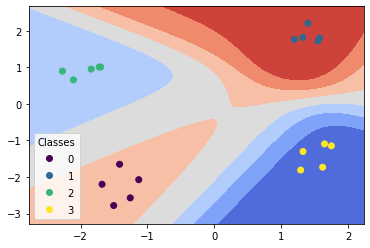

In [ ]:
word_embs = model.emb.weight.detach().numpy()
word_group_ids = [word_groups[w][1] for w in word_enc.classes_]
visualize_attention(word_embs, word_group_ids, lambda x: amodel.get_attention_weights(x, False))

### 檢視序列中的注意力分數

In [ ]:
def predict_seq(idx):
  polarity, att_score = amodel(torch.tensor([seqs_ids[idx]]))
  print("{}: {:.4f}".format(" ".join(seqs_words[idx]), polarity.detach().item()))
  print("attention: {}".format(att_score.squeeze().detach().numpy()))

In [ ]:
amodel.emb(torch.tensor(seqs_ids[200]))

tensor([[ 1.5469,  1.7230],
        [-2.1061,  0.6583],
        [ 1.2880, -1.8097]])

In [ ]:
predict_seq(10)
predict_seq(20)
predict_seq(200)

作業 學校 好吃: 0.9984
attention: [0.15524924 0.01811317 0.82663757]
電影 好吃 學校: 0.9988
attention: [0.14751312 0.83420783 0.01827904]
難聽 音樂 學校: 0.0007
attention: [0.9862593  0.01226216 0.00147855]
